# Analysis of the Titanic

This analysis aims to explore the Titanic dataset to uncover meaningful patterns and insights about the passengers.

The process involves three key steps: data cleaning, exploratory data analysis (EDA), and the application of a logistic regression model to predict survival outcomes.

## Importing Required Libraries

In [1]:
import warnings
from typing import Dict, List, Union

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

## Data Cleaning

### First Visual Inspection

In [2]:
df = pd.read_csv("data/Titanic-Dataset.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


According to [Thomas E. Cason](https://campus.lakeforest.edu/frank/FILES/MLFfiles/Bio150/Titanic/TitanicMETA.pdf) we have the following variable descriptions:

 - `Survived` => Survival (0 = No; 1 = Yes)
 - `Pclass` => Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
 - `Name` => Passenger Full Name
 - `Sex` => Male or Female ('male' and 'female')
 - `Age` => Age in years of the passenger
 - `SibSp` => Number of Siblings/Spouses Aboard
 - `Parch` => Number of Parents/Children Aboard
 - `Ticket` => Ticket Number
 - `Fare` => Passenger Fare (British pound)
 - `Cabin` => Cabin Number
 - `Embarked` => Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

In [3]:
df.shape

(891, 12)

There seem to be a total of `891` passengers listed in this dataset set.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Based on this new information we should probably transform the data to make it more understandable.

- `PassengerId` is a unique identifier for each passenger and does not provide any useful information for our analysis. We can drop this column.
- `Name` can be dropped as well as it does not provide any useful information for our analysis.
- `Ticket` can be dropped as well as it does not provide any useful information for our analysis.
- `Sex` can be transformed into either 0 or 1 for male and female respectively.
- `Sex` and `Embarked` can be transformed into categories

In [5]:
df.drop(columns=['PassengerId', 'Name', 'Ticket'], inplace=True)
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

for col in ['Sex','Embarked']:
    df[col] = df[col].astype('category')

Moreover, the above reveals that a there are missing values in the `Age`, `Cabin` and `Embarked` columns.

In order to have a better visual understanding lets plot a heatmap to see the missing values.

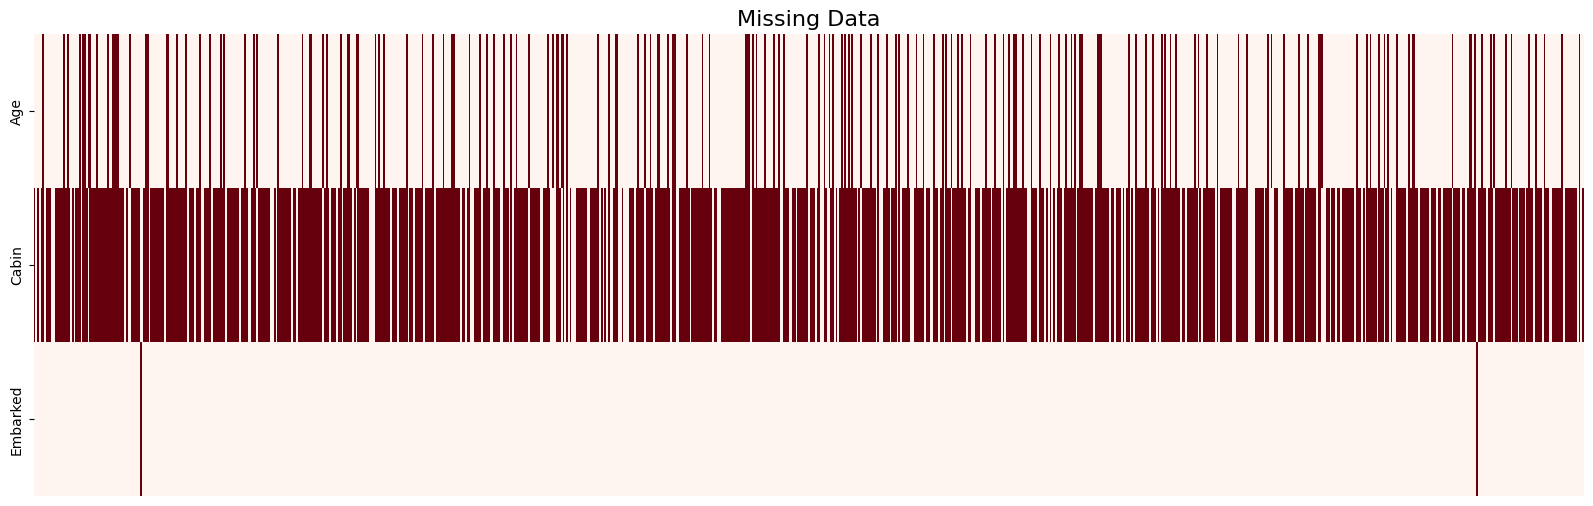

In [6]:
plt.figure(figsize=(20, 6))
sns.heatmap(df[['Age', 'Cabin', 'Embarked']].isnull().T, cbar=False, cmap='Reds', xticklabels=False)
plt.title('Missing Data', fontsize=16)
plt.show()

In [7]:
def print_missing_values_percentage(df: pd.DataFrame, columns: List[str]) -> None:
    """
    Prints the percentage of missing values for specified columns in a DataFrame.

    :param df: The pandas DataFrame to analyze.
    :param columns: A list of column names to check for missing values.
    """
    for column in columns:
        if column in df.columns:
            missing_percentage = df[column].isna().sum() / df[column].shape[0]
            print(f"Percentage of missing values in '{column}' column: {missing_percentage:.2%}")
        else:
            print(f"Column '{column}' does not exist in the DataFrame.")

print_missing_values_percentage(df, ['Age', 'Cabin', 'Embarked'])

Percentage of missing values in 'Age' column: 19.87%
Percentage of missing values in 'Cabin' column: 77.10%
Percentage of missing values in 'Embarked' column: 0.22%


The `Age` variable has approximately 19.87% missing values, which is a manageable proportion for "data imputation" using values derived from other columns.\
The `Embarked` variable has only 0.22% missing values (two data points), which is negligible and can be safely dropped without significantly impacting the analysis.

In contrast, the `Cabin` column has too much missing data to be effectively used in its current form, hence it will be dropped.

In [8]:
df.drop(columns=['Cabin'], inplace=True)
df.dropna(subset=['Embarked'], inplace=True)
print(f"Now we 'only' have {df.shape[0]} data points left.")

Now we 'only' have 889 data points left.


### Data Imputation

I want to investigate a better approach for filling the missing values in the `Age` variable, rather than simply using the overall average (global mean).

My hypothesis is that `Age` is strongly influenced by Passenger Class `Pclass` and `Sex`.\
The reasoning behind this is that 1st class passengers, being generally wealthier during that time, were likely older compared to those in 3rd class.\
Additionally, women might have tended to be younger than their male counterparts.

To validate this assumption, I'll analyze the data and see if it holds true.

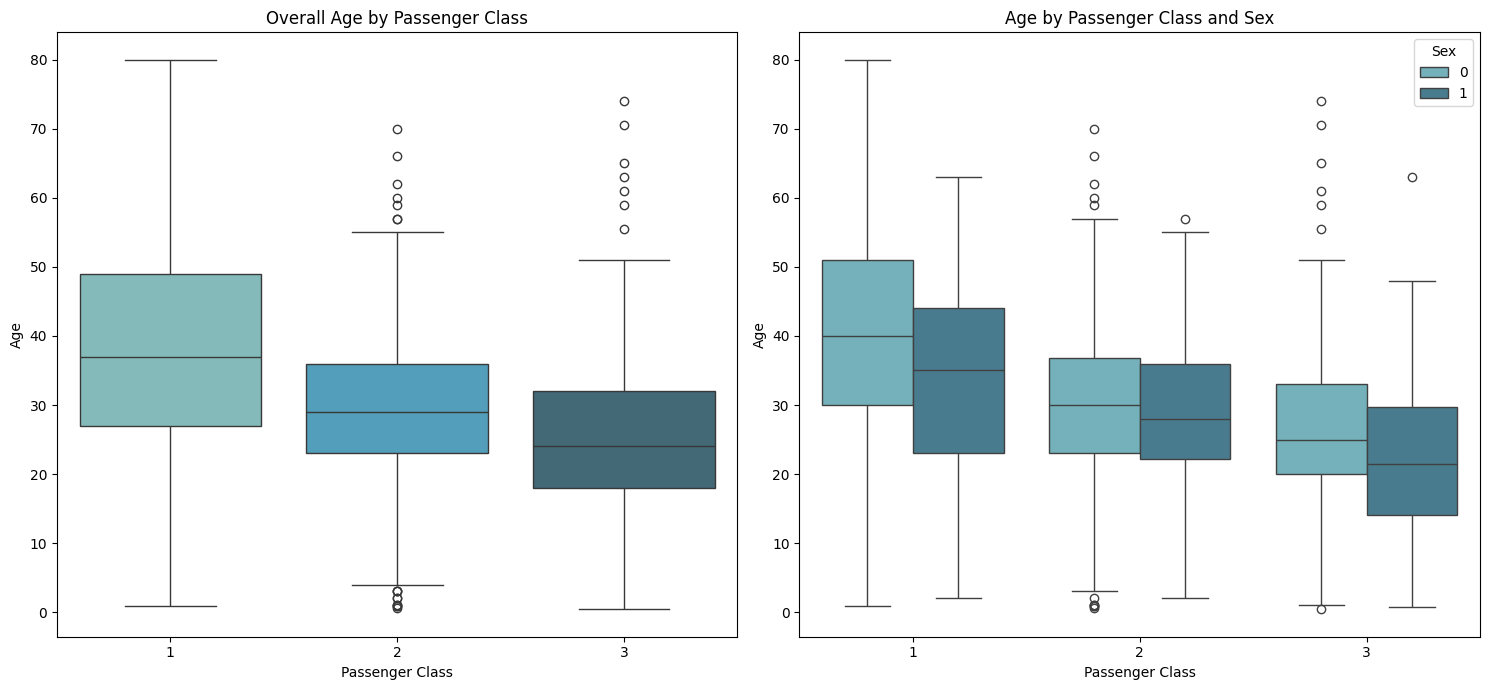

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

sns.boxplot(x='Pclass', y='Age', data=df, palette='GnBu_d', ax=axes[0])
axes[0].set_title('Overall Age by Passenger Class')
axes[0].set_xlabel('Passenger Class')

sns.boxplot(x='Pclass', y='Age', hue='Sex', data=df, palette='GnBu_d', ax=axes[1])
axes[1].set_title('Age by Passenger Class and Sex')
axes[1].set_xlabel('Passenger Class')
axes[1].legend(title='Sex')

plt.tight_layout()
plt.show()

The left plot shows the **overall age distribution** among the passenger classes.\
The box plot reveals a larger interquartile range (IQR) suggesting that 1st class passengers had a broader spread of older ages.\
Most first class passengers where between 27 and 49 years old, while second and third class passengers were younger.\
However, we have more outliers indicated by the box plots for the second a third class passengers.

The right plot shows the **age distribution** among the passenger classes **separated by sex**.
The box plot reveals that **women were indeed younger than men** across all passenger classes.

The data and visualizations strongly support the hypothesis, hence let's build an imputation method that takes this into account.

In [10]:
# Pre-computed dictionary containing mean ages rounded by Sex and Pclass
MEAN_AGE_BY_PCLASS_AND_SEX_ROUNDED: Dict[str, Dict[int, float]] = (
    df.groupby(['Sex', 'Pclass'])['Age']
    .mean()
    .round()
    .unstack()
    .to_dict()
)
MEAN_AGE_BY_PCLASS_AND_SEX_ROUNDED

{1: {0: 41.0, 1: 34.0}, 2: {0: 31.0, 1: 29.0}, 3: {0: 27.0, 1: 22.0}}

Let's impute the `Age` by the above values for 1-3 class passengers by sex (0 or 1).

In [11]:
def impute_age(row: pd.Series) -> Union[float, None]:
    """
    Impute missing age based on the mean age for the corresponding Sex and Passenger Class (Pclass).

    Parameters:
        row (pd.Series): A row of the DataFrame containing 'Age', 'Pclass', and 'Sex'.

    Returns:
        float: The imputed age if missing.
        None: Returns None if 'Sex' or 'Pclass' is invalid or not in the precomputed dictionary.
    """
    age = row['Age']
    sex = row['Sex']
    pclass = row['Pclass']
    
    if pd.notnull(age):
        return age

    # Validate input before attempting to retrieve mean age
    if pclass not in MEAN_AGE_BY_PCLASS_AND_SEX_ROUNDED:
        raise ValueError(
            f"Invalid Pclass value '{pclass}'. Allowed values: {list(MEAN_AGE_BY_PCLASS_AND_SEX_ROUNDED.keys())}"
        )
    
    if sex not in MEAN_AGE_BY_PCLASS_AND_SEX_ROUNDED[pclass]:
        raise ValueError(
            f"Invalid Sex value '{sex}' for Pclass '{pclass}'. Allowed values: {list(MEAN_AGE_BY_PCLASS_AND_SEX_ROUNDED[pclass].keys())}"
        )
    
    return MEAN_AGE_BY_PCLASS_AND_SEX_ROUNDED[pclass][sex]

df['Age'] = df.apply(impute_age, axis=1)

In [12]:
df.isna().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

We have successfully imputed all missing values now.

## Exploratory Data Analysis

In the following section, we will take a closer look on what actual data tells us about the titanic passengers.

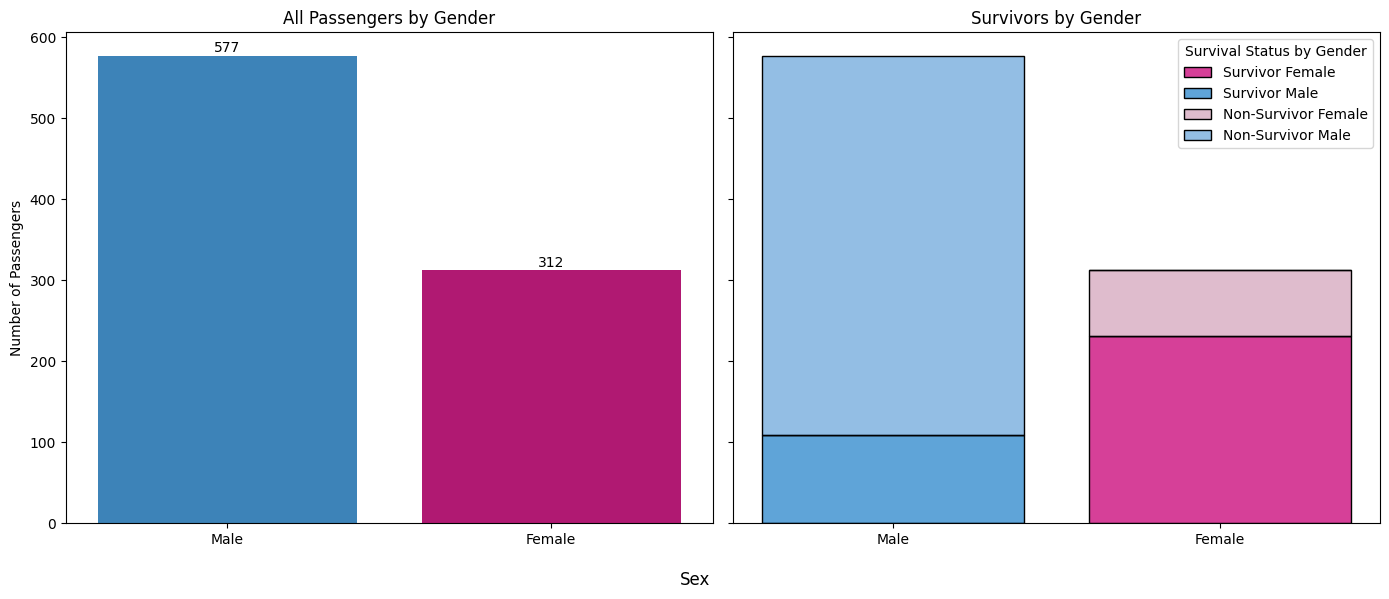

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
sns.countplot(ax=axes[0], x="Sex", data=df, palette={"0": "#2986cc", "1": "#c90076"})
axes[0].set_ylabel("Number of Passengers")
axes[0].set_title("All Passengers by Gender")
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(["Male", "Female"])
for bar in axes[0].patches:
    bar_height = bar.get_height()
    axes[0].text(
        bar.get_x() + bar.get_width() / 2,
        bar_height + 1,
        f"{int(bar_height)}",
        ha="center",
        va="bottom",
        fontsize=10
    )

# Create a temporary copy of df, modify it, then plot
df_mapper = df.copy()
df_mapper["Survival_Label"] = df_mapper["Survived"].map({0: "non-survivor", 1: "survivor"})
df_mapper["Sex_Survival"] = df_mapper["Survival_Label"] + "_" + df_mapper["Sex"].astype(str)

sns.histplot(
    ax=axes[1],
    data=df_mapper,
    x="Sex",
    hue="Sex_Survival",
    multiple="stack",
    shrink=0.8,
    palette={
        "non-survivor_0": "#6fa8dc",
        "non-survivor_1": "#d5a6bd",
        "survivor_0": "#2986cc",
        "survivor_1": "#c90076"
    },
    hue_order=["non-survivor_0", "non-survivor_1", "survivor_0", "survivor_1"]
)
axes[1].set_title("Survivors by Gender")
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(["Male", "Female"])
axes[1].legend(
    title="Survival Status by Gender",
    labels=[
        "Survivor Female", 
        "Survivor Male",
        "Non-Survivor Female", 
        "Non-Survivor Male"
    ],
    loc="upper right"
)

axes[0].set_xlabel("")
axes[1].set_xlabel("")
fig.supxlabel("Sex")

plt.tight_layout()
plt.show()
del df_mapper

The visualization highlights the gender distribution and survival outcomes of Titanic passengers.\
Males significantly outnumbered females, with **577 males** and **312 females** aboard the Titanic.

However, the survival outcomes reveal a strong gender disparity: **most males did not survive**, while a majority of females did, reflecting the "women and children first" protocol during the evacuation. This protocol is also known as the [Birkenhead Drill](https://www.historic-uk.com/CultureUK/Women-Children-First/).\
Despite females being fewer in number, their higher survival rate contrasts strongly with the predominantly high mortality rate among male passengers.\
This analysis underscores the influence of gender-based prioritization on survival outcomes. Moreover, the majority of the total passengers onboard did not survive.

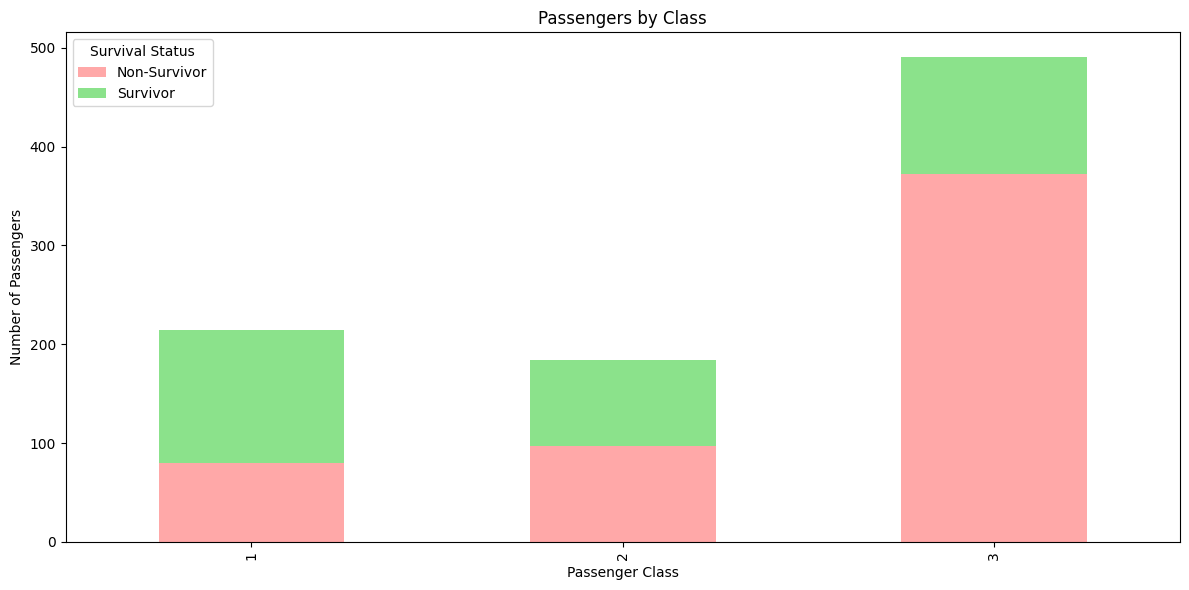

In [14]:
pclass = df.groupby(['Pclass', 'Survived']).Pclass.count().unstack()

ax = pclass.plot(
    kind='bar',
    stacked=True,
    title='Passengers by Class',
    color=['#ff9999', '#77dd77'],
    alpha=0.85,
    figsize=(12, 6)
)

ax.set_xlabel("Passenger Class")
ax.set_ylabel("Number of Passengers")
ax.legend(['Non-Survivor', 'Survivor'], title="Survival Status", loc="upper left")
plt.tight_layout()
plt.show()

The visualization highlights the class distribution and survival outcomes of Titanic passengers.\
The **majority of passengers** aboard were from **third class**, indicating a large representation of lower-class travelers.

Survival outcomes, however, reveal differences between classes:

- **First-class passengers** had the highest survival rate, with a significant portion surviving the disaster.
- In contrast, the majority of **second-class** and **third-class passengers** did not survive, reflecting a noticeable difference in survival rates across classes.

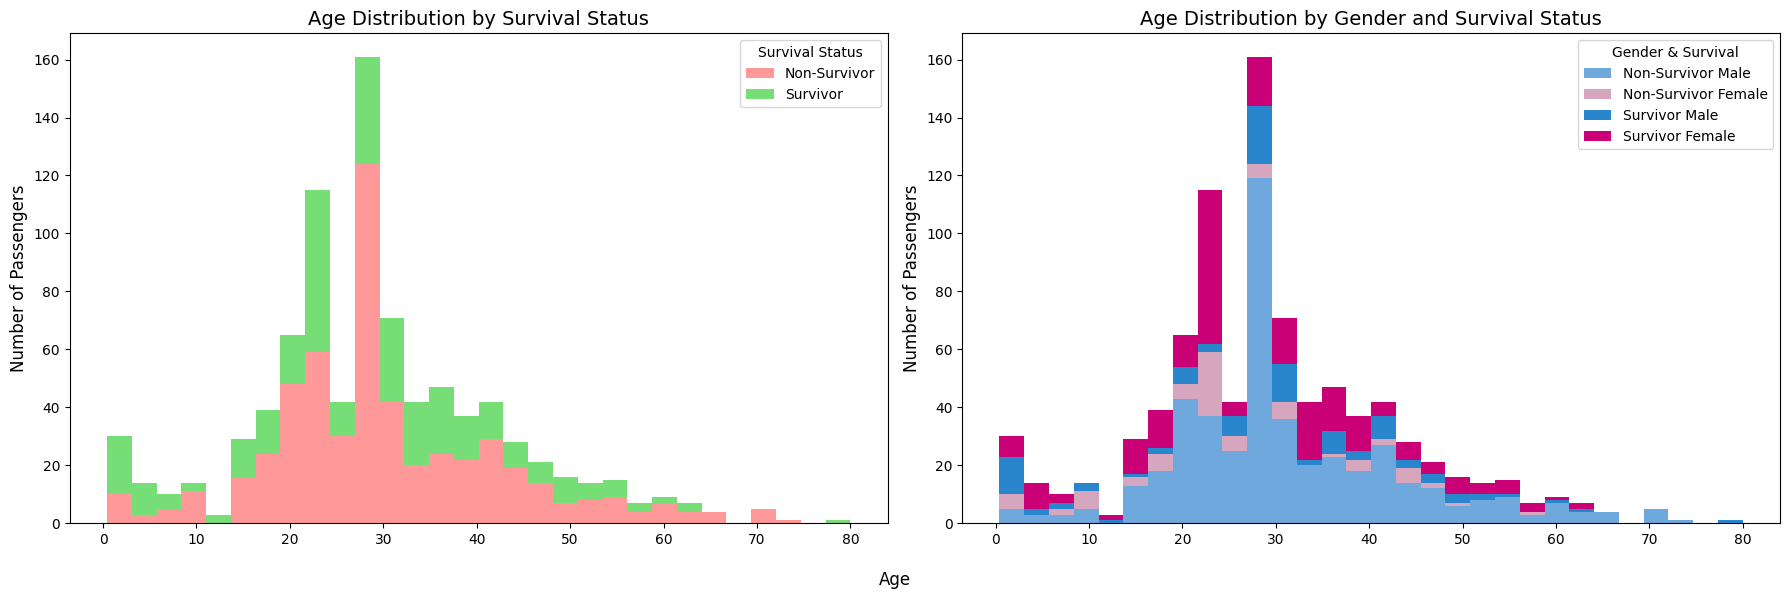

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

survived = df[df['Survived'] == 1]['Age']
non_survived = df[df['Survived'] == 0]['Age']

axes[0].hist(
    [non_survived, survived],
    bins=30,
    stacked=True,
    color=['#ff9999', '#77dd77'],
    label=['Non-Survivor', 'Survivor']
)
axes[0].set_ylabel('Number of Passengers', fontsize=12)
axes[0].set_title('Age Distribution by Survival Status', fontsize=14)
axes[0].legend(title="Survival Status")

df_mapper = df.copy()
df_mapper["Survival_Label"] = df_mapper["Survived"].map({0: "non-survivor", 1: "survivor"})
df_mapper["Sex_Survival"] = df_mapper["Survival_Label"] + "_" + df_mapper["Sex"].astype(str)

palette = {
    "non-survivor_0": "#6fa8dc",
    "non-survivor_1": "#d5a6bd",
    "survivor_0": "#2986cc",
    "survivor_1": "#c90076"
}
categories = ["non-survivor_0", "non-survivor_1", "survivor_0", "survivor_1"]
data = [df_mapper[df_mapper["Sex_Survival"] == category]["Age"] for category in categories]
colors = [palette[category] for category in categories]
labels = ["Non-Survivor Male", "Non-Survivor Female", "Survivor Male", "Survivor Female"]

axes[1].hist(
    data,
    bins=30,
    stacked=True,
    color=colors,
    label=labels
)

axes[1].set_ylabel('Number of Passengers', fontsize=12)
axes[1].set_title('Age Distribution by Gender and Survival Status', fontsize=14)
axes[1].legend(title="Gender & Survival")

axes[0].set_xlabel("")
axes[1].set_xlabel("")
fig.supxlabel("Age", fontsize=12)

plt.tight_layout()
plt.show()

The age distribution reveals that the **majority of passengers** were between the **ages of 20 and 40**, indicating a large representation of young and middle-aged adults aboard.

Survival outcomes, however, show clear patterns across age groups and gender:
- **Children under 10** had a higher survival rate, reflecting prioritization during evacuation, consistent with the "women and children first" protocol.
- For passengers aged **20 to 40**, the majority did not survive, as indicated by the dominance of non-survivor counts in these age bins. Female passengers in this group had noticeably better survival outcomes.
- Among **"older" passengers** (over 50), survival numbers were notably lower, possibly due to physical limitations during evacuation.

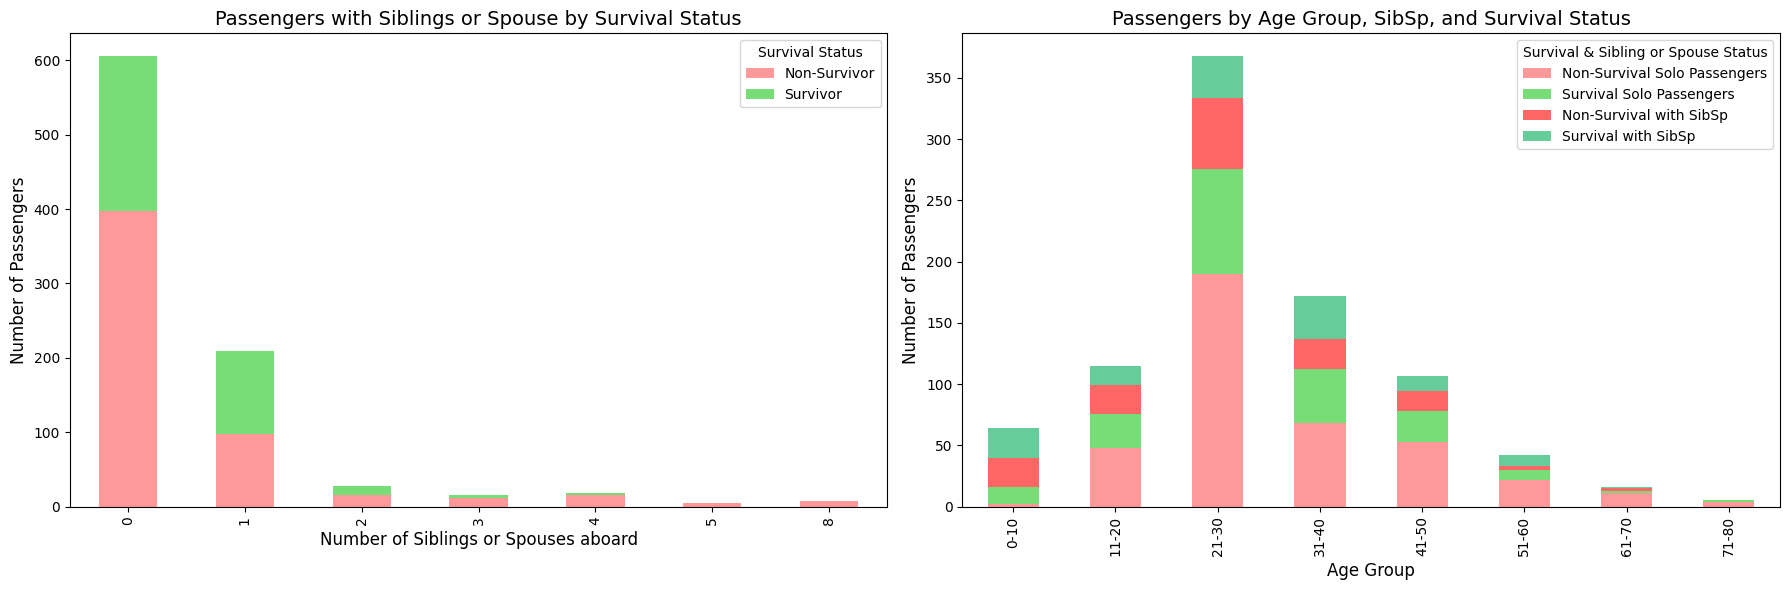

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sibsp = df.groupby(['SibSp', 'Survived']).SibSp.count().unstack(fill_value=0)
sibsp.plot(
    kind='bar',
    stacked=True,
    color=['#ff9999', '#77dd77'],
    ax=axes[0]
)

axes[0].set_title('Passengers with Siblings or Spouse by Survival Status', fontsize=14)
axes[0].set_xlabel('Number of Siblings or Spouses aboard', fontsize=12)
axes[0].set_ylabel('Number of Passengers', fontsize=12)
axes[0].legend(title="Survival Status", labels=['Non-Survivor', 'Survivor'])

age_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80]
age_labels = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80']

df_mapper = df.copy()
df_mapper['Age Group'] = pd.cut(df_mapper['Age'], bins=age_bins, labels=age_labels, right=True)

solo_passengers = df_mapper[df_mapper['SibSp'] == 0]
with_companions = df_mapper[df_mapper['SibSp'] > 0]

solo_group = solo_passengers.groupby(['Age Group', 'Survived']).size().unstack(fill_value=0)
companion_group = with_companions.groupby(['Age Group', 'Survived']).size().unstack(fill_value=0)

data_combined = pd.DataFrame({
    'Non-Survival Solo Passengers': solo_group[0],
    'Survival Solo Passengers': solo_group[1],
    'Non-Survival with SibSp': companion_group[0],
    'Survival with SibSp': companion_group[1]
}).fillna(0)

data_combined.plot(
    kind='bar',
    stacked=True,
    color=['#ff9999', '#77dd77', '#ff6666', '#66cc99'],  # Colors for categories
    ax=axes[1]
)

axes[1].set_title('Passengers by Age Group, SibSp, and Survival Status', fontsize=14)
axes[1].set_xlabel('Age Group', fontsize=12)
axes[1].set_ylabel('Number of Passengers', fontsize=12)
axes[1].legend(title='Survival & Sibling or Spouse Status')

plt.tight_layout()
plt.show()
del df_mapper

The majority of passengers were **single travelers**, with **no siblings or spouses aboard**, making up the largest group.

Survival outcomes, however, vary based on family size and age:
- Among **elderly passengers** (over 50), the majority traveled **alone**, which likely contributed to their lower survival rates due to physical limitations and the absence of family support during the evacuation process.
- One might come to the conclusion, that those with one sibling or spouse had higher survival rates compared to solo travelers, however most elderly person were solo travelers.

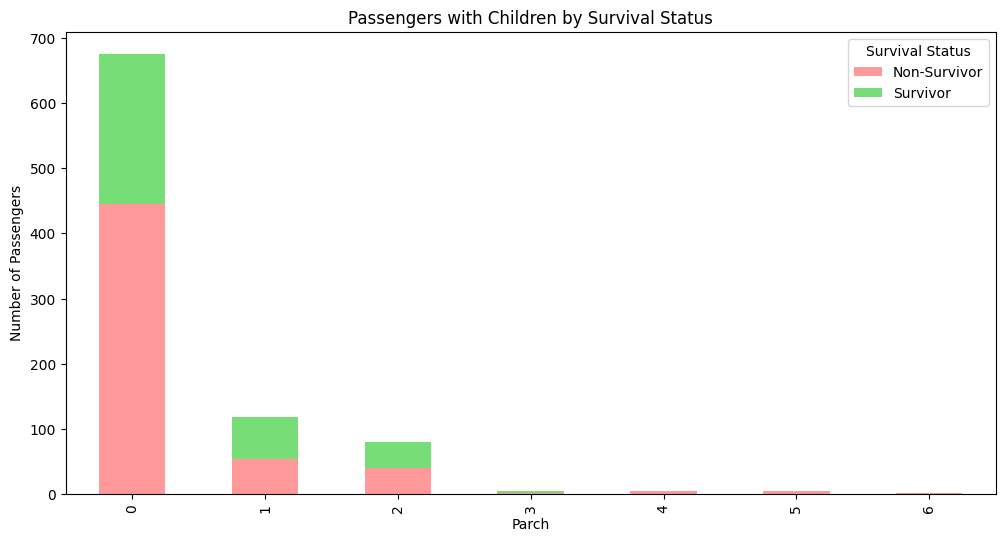

In [17]:
parch = df.groupby(['Parch','Survived']).Parch.count().unstack()
ax = parch.plot(kind = 'bar', stacked = True, color = ['#ff9999', '#77dd77'], figsize=(12, 6))
ax.set_title('Passengers with Children by Survival Status')
ax.set_xlabel('Parch')
ax.set_ylabel('Number of Passengers')
ax.legend(labels=['Non-Survivor', 'Survivor'], title="Survival Status")
plt.show()

Passengers traveling with children reveals distinct patterns in survival outcomes:
- The **majority of passengers** aboard did not have children, forming the largest group. Among them, **most did not survive**, as indicated by the dominant non-survivor count.
- Passengers with **one or two children** had noticeably higher survival rates, with roughly half of them surviving the disaster.

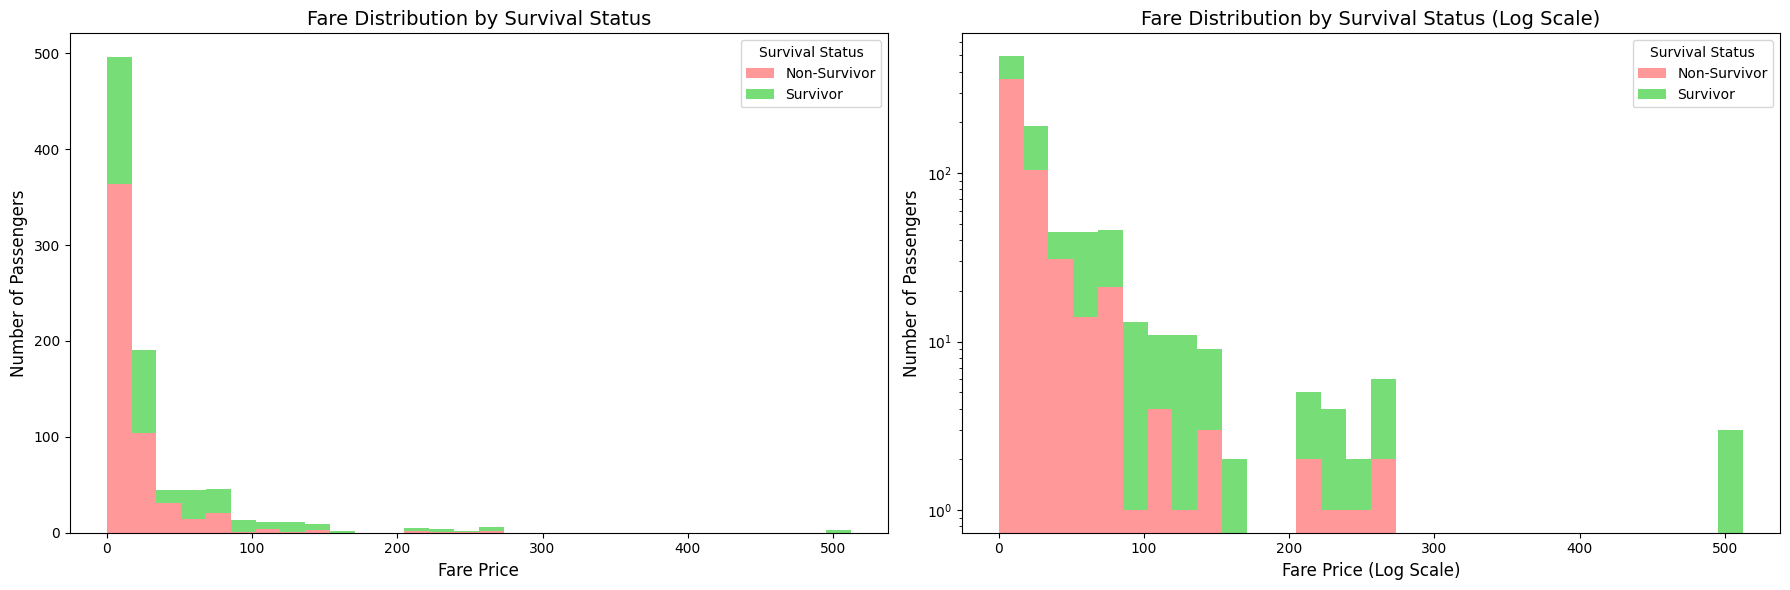

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

survived_fare = df[df['Survived'] == 1]['Fare']
non_survived_fare = df[df['Survived'] == 0]['Fare']

axes[0].hist(
    [non_survived_fare, survived_fare],
    bins=30,
    stacked=True,
    color=['#ff9999', '#77dd77'],
    label=['Non-Survivor', 'Survivor']
)

axes[0].set_title('Fare Distribution by Survival Status', fontsize=14)
axes[0].set_xlabel('Fare Price', fontsize=12)
axes[0].set_ylabel('Number of Passengers', fontsize=12)
axes[0].legend(title="Survival Status")

axes[1].hist(
    [non_survived_fare, survived_fare],
    bins=30,
    stacked=True,
    color=['#ff9999', '#77dd77'],
    label=['Non-Survivor', 'Survivor']
)

axes[1].set_title('Fare Distribution by Survival Status (Log Scale)', fontsize=14)
axes[1].set_xlabel('Fare Price (Log Scale)', fontsize=12)
axes[1].set_ylabel('Number of Passengers', fontsize=12)
axes[1].set_yscale('log')
axes[1].legend(title="Survival Status")

plt.tight_layout()
plt.show()

The fare distribution reveals a pattern to survival outcome:
- Passengers who paid **over $100** for their tickets had a **higher survival rate**, suggesting that higher fares were associated with better access to lifeboats.

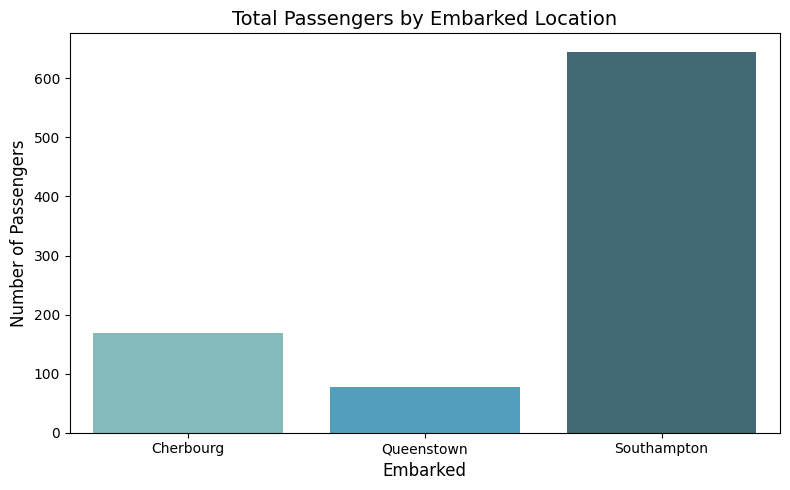

In [19]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Embarked', data=df, palette='GnBu_d')
plt.xlabel('Embarked', fontsize=12)
plt.ylabel('Number of Passengers', fontsize=12)
plt.title('Total Passengers by Embarked Location', fontsize=14)
plt.xticks(ticks=[0, 1, 2], labels=['Cherbourg', 'Queenstown', 'Southampton'])  # Replace C, Q, S
plt.tight_layout()
plt.show()

Just for the sake of completeness let's also illustrate that most passengers boarded the ship in Southampton.\
While Southampton served as the primary point of embarkation, there is no meaningful correlation between embarkation location and survival status.\
Any perceived link is likely coincidental or spurious correlation without strong statistical evidence to support it.

#### Conclusion
The Exploratory Data Analysis provides a comprehensive exploration of Titanic passengers.

- **Gender**: The "women and children first" protocol [Birkenhead Drill](https://www.historic-uk.com/CultureUK/Women-Children-First/) significantly influenced survival rates, with females having a higher chance of survival despite being fewer in number. Males, while more numerous, experienced significantly higher mortality rates.
- **Class**: Socioeconomic status played a pivotal role in survival outcomes. First-class passengers had the highest survival rates, reflecting their preferential access to lifeboats, while the majority of second- and third-class passengers faced devastating survival odds.
- **Age**: Younger children benefited from prioritization during evacuation, exhibiting the highest survival rates. Conversely, passengers aged 20-40 and the elderly experienced lower survival chances, influenced by physical challenges and situational disadvantages.
- **Family Size**: Passengers traveling alone or without children were the most vulnerable, particularly among elderly individuals. Those with one family member—such as a sibling or spouse—had improved survival rates, emphasizing the role of familial support during crises.
- **Fare and Socioeconomic Indicators**: Higher ticket fares correlated with greater survival likelihood, underscoring differences in access to lifeboats and resources based on economic status.
- **Embarkation**: While Southampton served as the primary point of embarkation, no significant relationship was found between embarkation location and survival outcomes.


## Logistic Regresion Model

In [20]:
features = df.drop(['Survived', 'Embarked'], axis=1)  # Features: All columns except 'Survived' and 'Embarked' (note previous plot for more information, why its left out)
target = df['Survived']  # Target variable: 'Survived'

# Perform 80/20 train-test split (train on 80% and use 20% to test the logistic regression model)
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)

logistic_model = LogisticRegression()
logistic_model.fit(features_train, target_train)
target_predictions = logistic_model.predict(features_test)

# Display the Confusion Matrix
print('Confusion Matrix')
print(confusion_matrix(target_test, target_predictions))
print('--' * 40)

# Display the Classification Report
print('Classification Report')
print(classification_report(target_test, target_predictions))

# Calculate and display accuracy
print('--' * 40)
logistic_model_accuracy = round(accuracy_score(target_test, target_predictions) * 100, 2)
print('Accuracy:', logistic_model_accuracy, '%')

Confusion Matrix
[[91 18]
 [15 54]]
--------------------------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.86      0.83      0.85       109
           1       0.75      0.78      0.77        69

    accuracy                           0.81       178
   macro avg       0.80      0.81      0.81       178
weighted avg       0.82      0.81      0.82       178

--------------------------------------------------------------------------------
Accuracy: 81.46 %


**Interpretation**

Accuracy:
- The model correctly predicts survival outcomes 81.46% of the time.

Precision:
- Precision measures how accurate the model's predictions of survival are.
- When the model predicts that a passenger survived, it is correct approximately 75% of the time for survivors (class 1) and 86% of the time for non-survivors (class 0).
- The average precision 82% is, hence the model predicts a passenger survived correctly 82% of the time. Acceptable, but not a very trustworthy model.

Recall (Sensitivity):
- Recall measures how well the model identifies survivors in the dataset.
- The model successfully identifies actual survivors 78% of the time and 81% on average for both surviving or not surviving.

F1 Score:
- The F1 Score balances these two metrics, providing a reliable performance measure.
- The F1 Score is 82% for the model, indicating a good balance between precision and recall. 
- Hence, if the model predicts someone survived, one can be quite confident that person actually did survive and it is not a false positive.